In [41]:
# Define autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
# Adopted from Andrew's project

from training_defs import load_spectral_data, get_dataloaders
from model import MLP
import torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt

X, y = load_spectral_data()
train_loader, val_loader = get_dataloaders(X, y)

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Layers
hidden_layers = [64, 128, 128, 62]

model = MLP(in_dim=X.shape[1], h_dim=hidden_layers, out_dim=3).to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 100
lconst_mult = 4
train_losses, val_losses = [], []

In [44]:
for epoch in range(1, n_epochs+1):
    model.train()
    tot_train = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss_pred = criterion(model(xb), yb)
        loss_pred.backward()
        optimizer.step()

        l_constraint = ((float(sum(model(xb)[0])) + float(sum(model(xb)[1]))) - 2) ** 2
        # Sum of the two floats should add up to 2. Not sure why there are two outputs yet...

        loss = loss_pred + (lconst_mult * l_constraint)
        tot_train += loss.item() * xb.size(0)
    train_losses.append(tot_train / len(train_loader.dataset))

    model.eval()
    tot_val = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            tot_val += criterion(model(xb), yb).item() * xb.size(0)
    val_losses.append(tot_val / len(val_loader.dataset))

    print(f"epoch {epoch:02d}  train loss: {train_losses[-1]:.4f}  val loss: {val_losses[-1]:.4f}")

epoch 01  train loss: 4.3291  val loss: 0.2115
epoch 02  train loss: 0.5226  val loss: 0.1781
epoch 03  train loss: 0.3932  val loss: 0.1637
epoch 04  train loss: 0.3394  val loss: 0.1558
epoch 05  train loss: 0.2366  val loss: 0.1586
epoch 06  train loss: 0.2657  val loss: 0.1481
epoch 07  train loss: 0.2265  val loss: 0.1513
epoch 08  train loss: 0.3722  val loss: 0.1560
epoch 09  train loss: 0.2449  val loss: 0.1382
epoch 10  train loss: 0.2332  val loss: 0.1263
epoch 11  train loss: 0.2694  val loss: 0.1404
epoch 12  train loss: 0.2172  val loss: 0.1215
epoch 13  train loss: 0.2216  val loss: 0.1225
epoch 14  train loss: 0.2283  val loss: 0.1241
epoch 15  train loss: 0.1916  val loss: 0.1329
epoch 16  train loss: 0.1967  val loss: 0.1228
epoch 17  train loss: 0.3329  val loss: 0.1140
epoch 18  train loss: 0.1593  val loss: 0.1366
epoch 19  train loss: 0.1913  val loss: 0.1234
epoch 20  train loss: 0.1861  val loss: 0.1080
epoch 21  train loss: 0.2011  val loss: 0.1080
epoch 22  tra

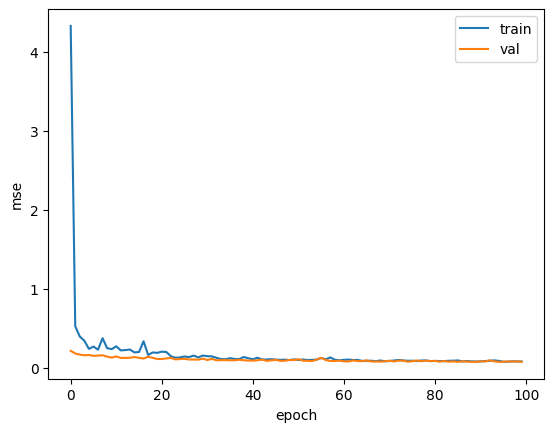

In [45]:
plt.plot(train_losses, label="train")
plt.plot(val_losses,   label="val")
plt.xlabel("epoch"); plt.ylabel("mse"); plt.legend(); plt.show()

torch.save(model.state_dict(), "spectra_mlp.pth")

In [46]:
import numpy as np
from sklearn.metrics import r2_score, root_mean_squared_error

model.eval()

all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(yb.cpu().numpy())

all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

r2 = r2_score(all_targets, all_preds, multioutput="uniform_average")
rmse = root_mean_squared_error(all_targets, all_preds)

print(f"validation r^2:  {r2:.4f}")
print(f"validation rmse: {rmse:.4f}")

validation r^2:  0.8668
validation rmse: 0.1063
